In [1]:
import numpy as np
import pandas as pd
# from src import timesfm
from src.timesfm import data_loader

import matplotlib.pyplot as plt

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


/home/v-zhangjiaw/miniconda3/envs/timesfm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM.
Loaded Jax TimesFM.
Loaded PyTorch TimesFM.


2024-12-29 15:34:19.901082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735486459.915510 3513914 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735486459.919882 3513914 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Utils

## Download the checkpoints

In [2]:
# # download checkpoint
# from huggingface_hub import snapshot_download

# # Download the checkpoint
# local_dir = "./timesfm_checkpoint"  # Replace with your desired directory
# snapshot_download(repo_id="google/timesfm-1.0-200m", local_dir=local_dir)

## Visualization

In [3]:
def plot_results_with_quantile(input_data, target_data, forecast_df):
    y_median = forecast_df[:, 5]  # 中位数（q=0.5）
    y_lower = forecast_df[:, 1]  # 最低分位数（q=0.1）
    y_upper = forecast_df[:, 9]  # 最高分位数（q=0.9）

    y_ground_truth = target_data
    
    y_ground_truth_past = input_data
    x_ground_truth_past = range(len(input_data))
    
    x = range(len(input_data), len(input_data) + len(target_data))

    plt.figure(figsize=(12, 6))
    plt.plot(x, y_median, label="Median Prediction (q=0.5)", color="green", linestyle="--")

    # Uncertainty
    plt.fill_between(x, y_lower, y_upper, color="green", alpha=0.2, label="Uncertainty (q=0.1 - q=0.9)")

    # Ground Truth
    plt.plot(x, y_ground_truth, label="Ground Truth (Target)", color="black")
    plt.plot(x_ground_truth_past, y_ground_truth_past, color="black")


    plt.ylabel("Forecast Value", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)  

    # 显示图形
    plt.tight_layout()
    plt.show()

# Prepare datasets

In [4]:
DATA_DICT = {
    "ettm2": {
        "boundaries": [34560, 46080, 57600],
        "data_path": "./datasets/ETT-small/ETTm2.csv",
        "freq": "15min",
    },
    "ettm1": {
        "boundaries": [34560, 46080, 57600],
        "data_path": "./datasets/ETT-small/ETTm1.csv",
        "freq": "15min",
    },
    "etth2": {
        "boundaries": [8640, 11520, 14400],
        "data_path": "./datasets/ETT-small/ETTh2.csv",
        "freq": "H",
    },
    "etth1": {
        "boundaries": [8640, 11520, 14400],
        "data_path": "./datasets/ETT-small/ETTh1.csv",
        "freq": "H",
    },
    "elec": {
        "boundaries": [18413, 21044, 26304],
        "data_path": "./datasets/electricity/electricity.csv",
        "freq": "H",
    },
    "traffic": {
        "boundaries": [12280, 14036, 17544],
        "data_path": "./datasets/traffic/traffic.csv",
        "freq": "H",
    },
    "weather": {
        "boundaries": [36887, 42157, 52696],
        "data_path": "./datasets/weather/weather.csv",
        "freq": "10min",
    },
}

In [5]:
def get_dataset(dataset, context_len, pred_len, batch_size):
    data_path = DATA_DICT[dataset]["data_path"]
    freq = DATA_DICT[dataset]["freq"]
    # int_freq = timesfm.freq_map(freq)
    boundaries = DATA_DICT[dataset]["boundaries"]

    data_df = pd.read_csv(open(data_path, "r"))


    ts_cols = [col for col in data_df.columns if col != "date"]
    num_cov_cols = None
    cat_cov_cols = None

    num_ts = len(ts_cols)
    
    dtl = data_loader.TimeSeriesdata(
        data_path=data_path,
        datetime_col="date",
        num_cov_cols=num_cov_cols,
        cat_cov_cols=cat_cov_cols,
        ts_cols=np.array(ts_cols),
        train_range=[0, boundaries[0]],
        val_range=[boundaries[0], boundaries[1]],
        test_range=[boundaries[1], boundaries[2]],
        hist_len=context_len,
        pred_len=pred_len,
        batch_size=num_ts,
        freq=freq,
        normalize=True,
        epoch_len=None,
        holiday=False,
        permute=True,
    )
    train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
    val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
    test_batches = dtl.tf_dataset(mode="test", shift=pred_len)
    
    return train_batches, val_batches, test_batches

# Load tfm with torch version to ensure gradient backpropagation

In [6]:
from timesfm_torch.model.timesfm import TimesFm
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
context_length = 256
prediction_length = 96
batch_size = 32
dataset = "etth1"

In [8]:
input_ts = torch.rand((batch_size, context_length)).to('cuda') # Input shape: (batch_size, context_len)
# TODO: check the hyperparam setting of TimesFM (an unofficial implementation from timesfm_torch)
tfm = TimesFm(
	context_len=context_length,
	input_patch_len=batch_size,
	output_patch_len=prediction_length,
	# horizon_len=prediction_length
	).to(device)

# TODO: load pretrained model
# # tfm.load_from_checkpoint(ckpt_dir='timesfm-1.0-200m/checkpoints')
# # tfm.load_from_checkpoint(ckpt_dir=f"/data/users/zhangmingkun1234/timesfm/ckpt/")
# checkpoint_path = '/data/users/zhangmingkun1234/timesfm/torch_model.ckpt'
# loaded_checkpoint = torch.load(checkpoint_path, weights_only=True)
# tfm.load_state_dict(loaded_checkpoint)

# checkpoint_path = 'timesfm-1.0-200m/checkpoints'

# output_ts = tfm(input_ts.to(device)) # Output shape: (batch_size, patch_num, horizon_len, num_outputs)

In [10]:
loaded_checkpoint = '/home/v-zhangjiaw/code/timesfm/timesfm_torch/ckpt'
tfm.load_from_checkpoint(loaded_checkpoint)

# Inference on clean data

In [11]:
mae_losses = []
mse_losses = []

forecasts_list = []
quantile_forecasts_list = []
pred_target = []
input_data = []

train_batches, val_batches, test_batches = get_dataset(dataset, context_length, prediction_length, batch_size)
for batch in test_batches.as_numpy_iterator():
    past = batch[0]
    actuals = batch[3]
    past_tensor = torch.tensor(past, requires_grad=True)
    actuals_tensor = torch.tensor(actuals)
    past_tensor = past_tensor.to(device)
    actuals_tensor = actuals_tensor.to(device)
    # forecasts, quantile_forecasts = tfm.forecast(list(past), [0] * past.shape[0], normalize=True)
    # forecasts = forecasts[:, 0 : actuals.shape[1]]
    forecasts = tfm(past_tensor.to(device), freq=0)
    # TODO: check the following processing of model output
    quantile_forecasts = forecasts[:,:,:actuals_tensor.size(1),:]
    forecasts = forecasts[:,0,:actuals_tensor.size(1),0]
    
    input_data.append(past_tensor)
    pred_target.append(actuals_tensor)
    forecasts_list.append(forecasts)
    quantile_forecasts_list.append(quantile_forecasts)
    
    # mse_losses.append(np.mean(np.square(forecasts - actuals)))
    # mae_losses.append(np.abs(forecasts - actuals).mean())
    mse_losses.append((forecasts - actuals_tensor) ** 2)
    mae_losses.append(torch.abs(forecasts - actuals_tensor))
    
	# TODO: for debug mode, only consider the first batch
    break

average_mse_loss = torch.mean(torch.cat(mse_losses, dim=0))
average_mae_loss = torch.mean(torch.cat(mae_losses, dim=0))

print(f'Average MAE Loss: {average_mae_loss.item()}, Average MSE Loss: {average_mse_loss.item()}')

Instructions for updating:
Use output_signature instead


/home/v-zhangjiaw/code/timesfm/src/timesfm/data_loader.py:90: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(
Instructions for updating:
Use output_signature instead


I0000 00:00:1735486469.874364 3513914 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77431 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0001:00:00.0, compute capability: 8.0


Average MAE Loss: 0.84360271692276, Average MSE Loss: 1.7091566324234009


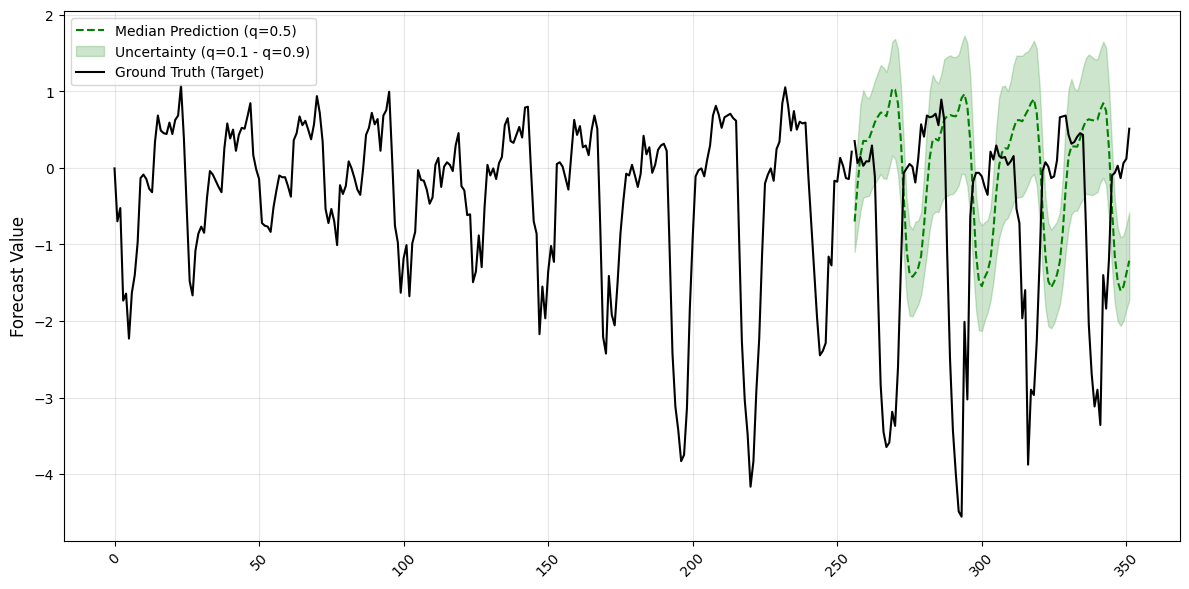

In [12]:
quantile_forecasts_tensor = torch.stack(quantile_forecasts_list,dim=0)
input_data_tensor = torch.stack(input_data,dim=0)
pred_target_tensor = torch.stack(pred_target,dim=0)

plot_results_with_quantile(input_data_tensor.cpu().detach()[0,0], pred_target_tensor.cpu().detach()[0,0], quantile_forecasts_tensor[0,0, 0,: ,:].cpu().detach())

# Adversarial Attack on Series Data

In [19]:
import torch
import numpy as np

# PGD Attack function
def pgd_attack(model, past_tensor, actuals_tensor, epsilon=0.1, alpha=0.01, num_iterations=10):
    """
    Perform a PGD attack on the model's inputs.
    
    Parameters:
    - model: The forecasting model.
    - past_tensor: The input tensor (time series context).
    - actuals_tensor: The true values (actuals).
    - epsilon: The maximum perturbation allowed (L-inf bound).
    - alpha: The step size for each iteration.
    - num_iterations: The number of iterations for the attack.
    
    Returns:
    - perturbed_input: The perturbed input after the attack.
    """
    # Make the input tensor require gradients
    perturbed_input = past_tensor.clone().detach().requires_grad_(True).to(device)
    
    for _ in range(num_iterations):
        # Forward pass through the model with the current perturbed input
        forecasts = model(perturbed_input)
        quantile_forecasts = forecasts[:,:,:actuals_tensor.size(1),:]
        # TODO: check the processing of model output
        forecasts = forecasts[:,0,:actuals_tensor.size(1),0]
        
        # Compute the loss (e.g., MSE loss)
        loss = torch.mean((forecasts - actuals_tensor) ** 2)
        
        # Backpropagate to compute the gradients for PGD attack
        model.zero_grad()
        loss.backward()
        
        # Get the gradient of the input
        grad = perturbed_input.grad.data
        
		# TODO: More explorations on attack strategies and epsilon budget constraint
        # Apply the perturbation: perturb the input in the direction of the gradient
        perturbed_input.data = perturbed_input.data + alpha * torch.sign(grad)
        
        # Clip the perturbed input to be within epsilon ball of the original input
        perturbed_input.data = torch.clamp(perturbed_input.data, past_tensor - epsilon, past_tensor + epsilon)
        
        # Ensure the perturbed input requires gradients for the next iteration
        perturbed_input.requires_grad_(True)
    
    return perturbed_input

# PGD attack integrated into the inference loop
mae_losses = []
mse_losses = []

forecasts_list = []
quantile_forecasts_list = []
pred_target = []
input_data = []

train_batches, val_batches, test_batches = get_dataset(dataset, context_length, prediction_length, batch_size)
for batch in test_batches.as_numpy_iterator():
    past = batch[0]
    actuals = batch[3]
    past_tensor = torch.tensor(past, requires_grad=True)
    actuals_tensor = torch.tensor(actuals)
    past_tensor = past_tensor.to(device)
    actuals_tensor = actuals_tensor.to(device)
    
    perturbed_past_tensor = pgd_attack(tfm, past_tensor, actuals_tensor, epsilon=0.1, alpha=0.01, num_iterations=10, device=device)
    
    forecasts = tfm(perturbed_past_tensor)
    
	# TODO: same as inference on clean data
    quantile_forecasts = forecasts[:,:,:actuals_tensor.size(1),:]
    forecasts = forecasts[:,0,:actuals_tensor.size(1),0]
    
    input_data.append(perturbed_past_tensor)
    pred_target.append(actuals_tensor)
    forecasts_list.append(forecasts)
    quantile_forecasts_list.append(quantile_forecasts)
    
    mse_losses.append((forecasts - actuals_tensor) ** 2)
    mae_losses.append(torch.abs(forecasts - actuals_tensor))
    
    # For debug mode, only consider the first batch
    break

average_mse_loss = torch.mean(torch.cat(mse_losses, dim=0))
average_mae_loss = torch.mean(torch.cat(mae_losses, dim=0))

print(f'Average MAE Loss: {average_mae_loss.item()}, Average MSE Loss: {average_mse_loss.item()}')


/data/users/zhangmingkun1234/timesfm/src/timesfm/data_loader.py:90: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pd.date_range(


Average MAE Loss: 1.2107317447662354, Average MSE Loss: 2.774775981903076


In [20]:
batch_idx = 0
var_idx = 0

In [21]:
input_data = np.array(torch.tensor(input_data[batch_idx]).detach().cpu().numpy()) # [batch_size, var_num, context_length]
pred_target = np.array(pred_target[batch_idx].detach().cpu().numpy()) # [batch_size, var_num, pred_length]
forecasts_list = np.array(forecasts_list[batch_idx].detach().cpu().numpy()) # [batch_size, var_num, pred_length]
quantile_forecasts_list = np.array(quantile_forecasts_list[batch_idx].detach().cpu().numpy()) # [batch_size, var_num, pred_length, quantile_num]

/tmp/ipykernel_2165790/2786717682.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = np.array(torch.tensor(input_data[batch_idx]).detach().cpu().numpy()) # [batch_size, var_num, context_length]


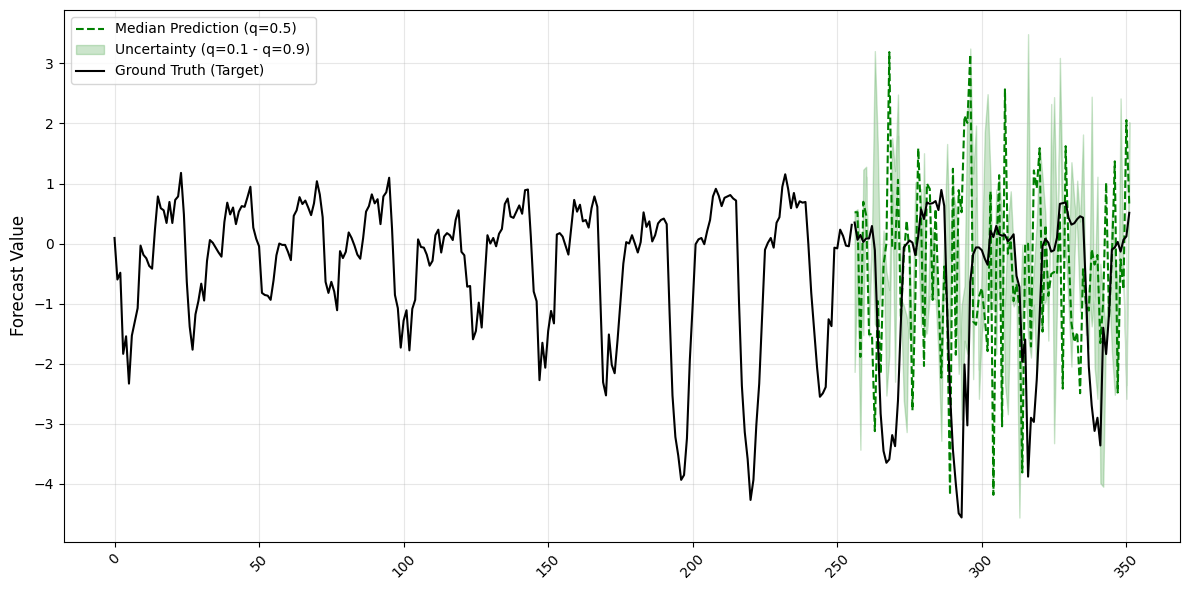

In [23]:
plot_results_with_quantile(input_data[var_idx], pred_target[var_idx], quantile_forecasts_list[batch_idx, var_idx])